In [25]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%pylab inline
import seaborn as sns
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


In [26]:
!ls

BankScoring.ipynb     BankScoring_v2.ipynb  laba04_train.csv
BankScoring_v1.ipynb  laba04_test.csv


In [27]:
train_df = pd.read_csv('laba04_train.csv')
test_df = pd.read_csv('laba04_test.csv')

In [28]:
#train_df = pd.concat([train_df, pd.get_dummies(train_df['PACK'], prefix="PACK")],axis=1)
#test_df = pd.concat([test_df, pd.get_dummies(train_df['PACK'], prefix="PACK")],axis=1)

train_df.drop(['Unnamed: 0', 'PACK'], axis=1, inplace=True)
test_df.drop(['Unnamed: 0', 'PACK'], axis=1, inplace=True)

In [29]:
test_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,44399,NaN,NaN,NaN,369576,128215,146871,258492,369600,481638,590818
CR_PROD_CNT_IL,44399,NaN,NaN,NaN,0.102029,0.419946,0,0,0,0,10
AMOUNT_RUB_CLO_PRC,39605,NaN,NaN,NaN,0.0440032,0.109723,0,NaN,NaN,NaN,1
PRC_ACCEPTS_A_EMAIL_LINK,19378,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0
APP_REGISTR_RGN_CODE,7525,NaN,NaN,NaN,51.2587,21.6515,1,NaN,NaN,NaN,89
PRC_ACCEPTS_A_POS,19378,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0
PRC_ACCEPTS_A_TK,19378,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0
TURNOVER_DYNAMIC_IL_1M,44399,NaN,NaN,NaN,0.00125581,0.0292088,0,0,0,0,1
CNT_TRAN_AUT_TENDENCY1M,9667,NaN,NaN,NaN,0.412448,0.314596,0.0144928,NaN,NaN,NaN,1
SUM_TRAN_AUT_TENDENCY1M,9667,NaN,NaN,NaN,0.408287,0.335829,0.000527158,NaN,NaN,NaN,1


In [30]:
train_df.shape, test_df.shape

((399589, 115), (44399, 114))

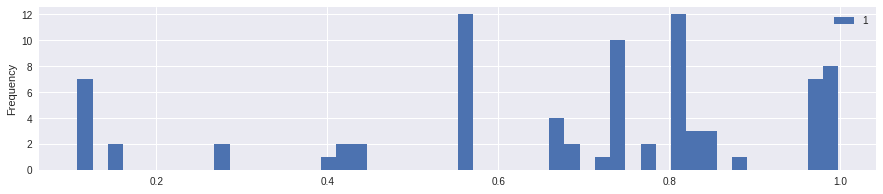

In [31]:
nan = []
for col in train_df.columns:
    if pd.isnull(train_df[col]).sum()/len(train_df[col]) > 0:
        nan.append([col, pd.isnull(train_df[col]).sum()/len(train_df[col])])
#print (pd.DataFrame(nan).to_string())
pd.DataFrame(nan).plot.hist(bins=50, figsize = [15,3])

                           0         1        2
0         AMOUNT_RUB_CLO_PRC  0.107933  float64
1   PRC_ACCEPTS_A_EMAIL_LINK  0.563789  float64
2          PRC_ACCEPTS_A_POS  0.563789  float64
3           PRC_ACCEPTS_A_TK  0.563789  float64
4         AMOUNT_RUB_SUP_PRC  0.107933  float64
5      PRC_ACCEPTS_A_AMOBILE  0.563789  float64
6             PRC_ACCEPTS_TK  0.563789  float64
7          PRC_ACCEPTS_A_MTP  0.563789  float64
8             CNT_ACCEPTS_TK  0.563789  float64
9         AMOUNT_RUB_NAS_PRC  0.107933  float64
10         CLNT_JOB_POSITION  0.406132   object
11       TRANS_COUNT_SUP_PRC  0.107933  float64
12         PRC_ACCEPTS_A_ATM  0.563789  float64
13           PRC_ACCEPTS_MTP  0.563789  float64
14       TRANS_COUNT_NAS_PRC  0.107933  float64
15           CNT_ACCEPTS_MTP  0.563789  float64
16       TRANS_COUNT_ATM_PRC  0.107933  float64
17        AMOUNT_RUB_ATM_PRC  0.107933  float64
18   CNT_TRAN_SUP_TENDENCY3M  0.440545  float64
19   SUM_TRAN_SUP_TENDENCY3M  0.440545  

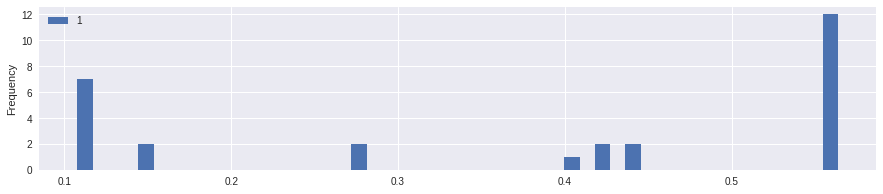

In [32]:
nan = []
for col in train_df.columns:
    if pd.isnull(train_df[col]).sum()/len(train_df[col]) <= 0.60 and pd.isnull(train_df[col]).sum()/len(train_df[col]) > 0:
        nan.append([col, pd.isnull(train_df[col]).sum()/len(train_df[col]), train_df[col].dtype])
print (pd.DataFrame(nan).to_string())
pd.DataFrame(nan).plot.hist(bins=50, figsize = [15,3])

In [33]:
for n in pd.DataFrame(nan).iloc[:,0]:
    if(train_df[n].dtype == np.float64 or train_df[n].dtype == np.int64):
        train_df[n] = train_df[n].fillna(train_df[n].median())
        test_df[n] = test_df[n].fillna(test_df[n].median())

                               0         1        2
0                             ID  0.000000    int64
1                 CR_PROD_CNT_IL  0.000000    int64
2             AMOUNT_RUB_CLO_PRC  0.000000  float64
3       PRC_ACCEPTS_A_EMAIL_LINK  0.000000  float64
4           APP_REGISTR_RGN_CODE  0.828932  float64
5              PRC_ACCEPTS_A_POS  0.000000  float64
6               PRC_ACCEPTS_A_TK  0.000000  float64
7         TURNOVER_DYNAMIC_IL_1M  0.000000  float64
8        CNT_TRAN_AUT_TENDENCY1M  0.782959  float64
9        SUM_TRAN_AUT_TENDENCY1M  0.782959  float64
10            AMOUNT_RUB_SUP_PRC  0.000000  float64
11         PRC_ACCEPTS_A_AMOBILE  0.000000  float64
12       SUM_TRAN_AUT_TENDENCY3M  0.687516  float64
13           CLNT_TRUST_RELATION  0.803858   object
14                PRC_ACCEPTS_TK  0.000000  float64
15             PRC_ACCEPTS_A_MTP  0.000000  float64
16          REST_DYNAMIC_FDEP_1M  0.000000  float64
17       CNT_TRAN_AUT_TENDENCY3M  0.687516  float64
18          

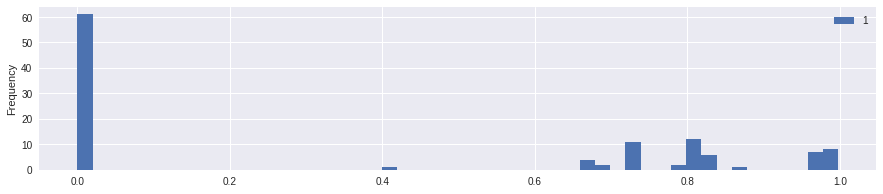

In [34]:
nan = []
for col in train_df.columns:
    if pd.isnull(train_df[col]).sum()/len(train_df[col]) >= 0:
        nan.append([col, pd.isnull(train_df[col]).sum()/len(train_df[col]), train_df[col].dtype])
print (pd.DataFrame(nan).to_string())
pd.DataFrame(nan).plot.hist(bins=50, figsize = [15,3])

In [35]:
for n in pd.DataFrame(nan).iloc[:,0]:
    #if train_df[n].dtype == np.object:
        train_df.drop([n], axis=1, inplace=True)
        test_df.drop([n], axis=1, inplace=True)
    #else:   
     #   train_df[n] = train_df[n].fillna(train_df[n].median())
      #  test_df[n] = test_df[n].fillna(test_df[n].median())

ValueError: labels ['TARGET'] not contained in axis

In [ ]:
y = train_df['TARGET']
train_df.drop(['TARGET'], axis=1, inplace=True)

In [ ]:
for e in list(set(train_df.columns)-set(test_df.columns)):
    print (e)

In [ ]:
train_df.drop(list(set(train_df.columns)-set(test_df.columns)), axis=1, inplace=True)

In [ ]:
#tree_params = {'max_depth': [2, 3], 'min_samples_leaf': [2, 3]}
tree_params = {
    'max_depth': range(2,10),
    'max_features': range(5,len(train_df.columns)),
    'class_weight':  ["balanced", "balanced_subsample"],
    'min_samples_leaf':  range(1,10)}

cf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10), n_jobs=-1, param_grid=tree_params, cv=5)

cf.fit(train_df,y)

In [ ]:
print("Best params:", cf.best_params_)
print("Best cross validaton score", cf.best_score_)

In [ ]:
pred_prob = pd.DataFrame(zip(test_df.ID,cf.predict_proba(test_df)[:,1]),columns=['id','target'])

In [ ]:
pred_prob.to_csv('~/lab04.csv', sep='\t', index=False)

In [ ]:
pred_prob.to_csv('~/lab04s.csv', sep='\t', index=False)